The point of this notebook is to consolidate work
Organization of workbooks
1. Organize 1 workbook for creating / optimizing / parameterizing notebooks
2. Organize 1 workbook for creating an adjusted Confusion matrix

Definition : adjusted confusion matrix takes into account or attempts to flag transaction the model notebook 1 spits out for refunding accounts.

Remember that DF1 Was used to model and therefore can't be used to test these functions.

In [282]:
#Imports
import os

#Basic Imports
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

#Models
from sklearn import ensemble
from sklearn import preprocessing as pp

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
## Unused at the moment
#from xgboost import XGBClassifier
#from sklearn import datasets
#Visualization
import seaborn as sns
import networkx as nx
plt.style.use("ggplot")
#Time
import time

In [4]:
os.chdir('..')
os.chdir('Thinkful Datasets')
os.chdir('Mobile Money Fraud')

In [5]:
from joblib import dump, load
xgb_grid_opt = load('grid_opt_df1')

In [6]:
## write a function to return common metrics to evalute a models performance on data
def model_evaluate(model,X_test,y_test):
    y_pred = model.predict(X_test)
    
    table_test = pd.crosstab(y_test, y_pred, margins=True)
    
    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    #Type 1 Error is False positive
    #Type 2 Error is False negative
    print((
        'Test set accuracy:\n'
        'Percent Type I errors: {}\n'
        'Percent Type II errors: {}'
    ).format(test_tI_errors, test_tII_errors))

    print('\n Accuracy by admission status')
    print(table_test)

    print('\n Percentage accuracy')
    print(model.score(X_tes t, y_test))

    cost = pd.DataFrame()
    cost['amount'] = X_test['amount']
    cost['type'] = X_test['type']
    cost['fraud'] = y_test.ravel()
    cost['prediction'] = y_pred.ravel()
    cost['isRefund'] = 0

    
    #Dollars saved catching fraud
    print('\nDollars saved catching fraud\n','${:,.2f}'.format(cost[(cost['fraud']==1) & (cost['prediction']==1)]['amount'].sum()))
    #Cost of fraud not caught
    print('\nDollars lost missing fraud\n','${:,.2f}'.format(cost[(cost['fraud']==1) & (cost['prediction']==0)]['amount'].sum()))
    #Difference
    print('\nDifference between lost and saved\n','${:,.2f}'.format(cost[(cost['fraud']==1) & (cost['prediction']==1)]['amount'].sum() - cost[(cost['fraud']==1) & (cost['prediction']==0)]['amount'].sum()))
    # Total Transacted
    print('\nTotal dollars transacted\n','${:,.2f}'.format(cost['amount'].sum()))
    
    # Cost of Case Load
    
    #write this cost function that includes the time value of the expected caseload
    return cost

In [7]:
## write a simple function to go through out new data

def model_data(df,model):
    # must change this to check if data is already in correct format.
    # change / reshape data
    df=df
    df.drop(['isFlaggedFraud','isUnauthorizedOverdraft'],1,inplace=True)
    df.rename(columns={'action':'type','oldBalanceOrig':'oldbalanceOrg','newBalanceOrig':'newbalanceOrig','oldBalanceDest':'oldbalanceDest','newBalanceDest':'newbalanceDest'},inplace=True)
    
    #encode type
    le = pp.LabelEncoder()
    le.fit(df['type'])
    df['type']=le.transform(df['type'])
    
    #split into dependant and independant variable(s)   
    X = df.drop(['isFraud','nameOrig','nameDest'],1)
    Y = df['isFraud']
    
    print('Starting prediction')
    
    #use model to predit
    
    cost = model_evaluate(model,X,Y)
    cost['nameOrig'] = df['nameOrig']
    cost['nameDest'] = df['nameDest']
    return cost

In [261]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 56A1-A9AC

 Directory of C:\Users\Zak White\appdata\local\programs\python\python36\Thinkful Datasets\Mobile Money Fraud

02/20/2019  12:42 PM    <DIR>          .
02/20/2019  12:42 PM    <DIR>          ..
02/20/2019  11:36 AM             2,362 Capstone Presentation Outline.txt
02/11/2019  09:42 PM             1,417 DrugNetworkOne.graphml
02/19/2019  03:53 PM            11,718 Eniac Digital Wallet.png
02/20/2019  12:42 PM           143,762 Focus.jpg
02/11/2019  09:37 PM           856,069 grid_opt_df1
02/19/2019  03:36 PM           128,136 Mobile Money Market Graphic.JPG
02/05/2019  10:50 AM       493,534,783 PS_20174392719_1491204439457_log.csv
02/05/2019  10:52 AM       303,922,029 Run1.csv
02/05/2019  10:54 AM       303,614,611 Run2.csv
02/05/2019  10:52 AM       298,699,248 Run3.csv
02/05/2019  10:53 AM       292,119,266 Run4.csv
02/05/2019  10:53 AM       310,220,911 Run5.csv
              12 File(s)  2,003,254,312 bytes
     

# Time to test the function on new data.

In [262]:
## Let's test our model on a hold out set of data that it has never seen before
df1 = pd.read_csv('Run2.csv')
cost_df1 = model_data(df1,xgb_grid_opt)

Starting prediction
Test set accuracy:
Percent Type I errors: 0.0002624220326785749
Percent Type II errors: 1.8851297672463193e-05

 Accuracy by admission status
col_0          0     1      All
isFraud                        
0        3339648   877  3340525
1             63  1357     1420
All      3339711  2234  3341945

 Percentage accuracy
0.9556338028169014

Dollars saved catching fraud
 $5,650,902,156.33

Dollars lost missing fraud
 $59,232,794.29

Difference between lost and saved
 $5,591,669,362.04

Total dollars transacted
 $494,420,812,047.07


So there are a few things to think about here when calculating dollars saved from fraud detection.

Things get a little screwy because what we have two occations to catch a fraudulent transaction.

Types of true negatives.

1. TNs that are TRANSFERs
2. FN that are TRANSFERs, but TNs that are CASH_OUTs
3. TNs that are both TRANSFERs and CASH_OUTs count the same as #1
Types of false negatives

1. FNs that are TRANSFERs and CASH_OUTs
Now we should categorize all our TNs and FNs as such. Then for each transaction.

The more sticky scenario is how do we factor this into our recall scoring metric (do this later)

First thing is to look at our FNs and what we're working with.

In [263]:
#see the break down of our FNs
# It looks like the majority of FNs we miss are Transfers (4) and are not CASH_OUTs
# This is really good news.
cost_df1[(cost_df1['prediction']==0) & (cost_df1['fraud']==1)]['type'].value_counts(normalize=True)

4    0.857143
1    0.142857
Name: type, dtype: float64

In [264]:
# Quickly compare this to what types all of our predictions are.
#cost_df1[(cost_df1['fraud']==1)]['type'].value_counts(normalize=True)

df1[df1['isFraud']==1]['type'].value_counts(normalize=True)

4    0.5
1    0.5
Name: type, dtype: float64

In [10]:
# Now we want to go over our data set and look for instances where we caught
# the fraudlent cashout, but not the fraudlent transfer and flag it as a potential refund.

# We also need to account for instances where a fraudlent transfer and the subsequent fraudlent cashout is predicted.
# If we assume that a transaction that is a transfew is potentially fraudlent then the subsequent cashout wouldn't take place.

### I think we need to add account details into this proposed function to ensure some parody

# when Tn=4 and Pn=0;
    #If Tn+1=1 and Pn+1=1:
        # Set 'refund' = 1
    #'refund' = 0
# PN = Predicted Negatives 'fraud'    
PN = cost_df1.loc[cost_df1['fraud']==1,:].copy()
PN.reset_index(drop=True,inplace=True)

In [11]:
PN

,amount,type,fraud,prediction,isRefund,nameOrig,nameDest
0,21220.42,4,1,1,0,C5103604942,CC8797415733
1,21220.42,1,1,1,0,CC8797415733,M5604194070
2,35.08,4,1,1,0,C9939793959,CC1789317029
3,35.08,1,1,1,0,CC1789317029,M7700199247
4,20438.34,4,1,1,0,C2262100519,CC3150846118
5,20438.34,1,1,1,0,CC3150846118,M0042054635
6,85.89,4,1,1,0,C7561096586,CC1852791396
7,85.89,1,1,1,0,CC1852791396,M2116507208
8,35.93,4,1,1,0,C0674840364,CC9403225619
9,35.93,1,1,1,0,CC9403225619,M8812070458


In [12]:
# This is important so we can test PP and make sure we aren't flagging false positives for a refund
#PP Predictive Positives 'not-fraud'
PP = cost_df1.loc[cost_df1['fraud']==0,:].copy()
PP.reset_index(drop=True,inplace=True)

3345074

In [35]:
cost_df1.head(10)

,amount,type,fraud,prediction,isRefund,nameOrig,nameDest
0,21220.42,4,1,1,1,C5103604942,CC8797415733
1,21220.42,1,1,1,0,CC8797415733,M5604194070
2,20.00,4,0,1,0,C0564937888,C0795684423
3,38107.35,0,0,0,0,C1958314419,M1796864206
4,369048.83,0,0,0,0,C1958314419,M1238486451
5,184841.44,0,0,0,0,C7873893880,M6956241720
6,168980.58,0,0,0,0,C4757971231,M9914166817
7,148101.29,0,0,0,0,C4757971231,M3290524027
8,220790.12,0,0,0,0,C4514036986,M3763844999
9,34114.50,0,0,0,0,C1496450731,M1023223354


In [265]:
#['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
#[0,1,2,3,4]
def adj_cheat(df):
            #if index
            #print(df.iloc[index+1,:])
    for i in range(len(df.index)):
        if i+1==(len(df.index)):
            break
        row = df.iloc[i,:]
        # look for the tranfers where we predicted fraud and was correct
        if (row['type']==4) and (row['fraud']==1) and (row['prediction']==1):
            # flag the transfer as being refunded
            df.at[i,'isRefund']=1
            #look at subsequent cash_out if it was "not caught" assume that it was because the transfer was caught
            #ensure that the amounts are the same "not a realistic assumption insitu"
            if (df.iloc[i+1,:]['type']==1) and (df.iloc[i+1,:]['fraud']==1) and (df.iloc[i+1,:]['prediction']==0) and (row['amount']==df.iloc[i+1,:]['amount']):
                df.iat[i+1,'prediction']==1
        # look for Cash_outs that were  predicted, but the previous transfer was not caught
        if (row['type']==1) and (row['fraud']==1) and (row['prediction']==1):
            #look at previous transfer and set prediction to 1 as the
            if (df.iloc[i-1,:]['type']==4) and (df.iloc[i-1,:]['fraud']==1) and (df.iloc[i-1,:]['prediction']==0) and (row['amount']==df.iloc[i-1,:]['amount']):
                df.at[i-1,'prediction']=1
                #print(df.iloc[i-1,:])
                df.at[i,'isRefund']=1
                #print("we found 1")
    return df

In [266]:
# Clearly something is up and that function is bloating out of control
# Let's cheat a bit.
cost_df1['isRefund'] = 0 #comment this out later, just to reset the refund column inbetween runs
cheat = cost_df1[((cost_df1['type']==1) | (cost_df1['type']==4)) & (cost_df1['fraud']==1)]
cheat.reset_index(inplace=True)
cheat.head(12)

,index,amount,type,fraud,prediction,isRefund,nameOrig,nameDest
0,0,8.34,4,1,1,0,C8832096033,CC9538703934
1,1,8.34,1,1,1,0,CC9538703934,M9218466852
2,4600,35.06,4,1,1,0,C0393672689,CC8909580957
3,4601,35.06,1,1,1,0,CC8909580957,M3963216482
4,5553,74.46,4,1,1,0,C8945485337,CC8698778416
5,5554,74.46,1,1,1,0,CC8698778416,M5932323725
6,5557,369785.65,4,1,0,0,C0503053151,CC6202999846
7,5558,369785.65,1,1,1,0,CC6202999846,M3930645032
8,5566,4.29,4,1,1,0,C0444644066,CC7379789289
9,5567,4.29,1,1,1,0,CC7379789289,M2641865691


In [267]:
# IT WORKS!!
test = adj_cheat(cheat)

test[test['prediction']==1]['isRefund'].value_counts(normalize=True)

1    0.5
0    0.5
Name: isRefund, dtype: float64

In [268]:
test['prediction'].value_counts()

#cost_df1.iloc[:10,].itterrows()
#maybe_refund(cost_df1.head())

1    1402
0      18
Name: prediction, dtype: int64

In [256]:
test[test['isRefund']==1]['amount'].sum()

2922004306.2799997

In [305]:
test[(test['fraud']==1) & (test['prediction']==0)]['amount'].sum()/2

3604973.87

Try to make some Presion Recall curves ???

In [257]:
from sklearn.metrics import average_precision_score, auc, roc_curve, precision_recall_curve



In [258]:
xgb_grid_opt

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'loss': ['deviance', 'exponential'], 'learning_rate': [0.1], 'n_estimators': [800], 'subsample': [0.8], 'min_samples_split': [2], 'min_weight_fraction_leaf': [0, 0.1], 'max_depth': [2], 'tol': [1e-05], 'random_state': [7351]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=10)

In [259]:
### Oh god damnit that previous function isn't going to play nice
### With what I want to do :*( :*( 

# let's make our own function ...... I guess




In [260]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,4,21220.42,C5103604942,21220.42,0.00,CC8797415733,0.00,21220.42,1
1,0,1,21220.42,CC8797415733,21220.42,0.00,M5604194070,0.00,0.00,1
2,0,4,20.00,C0564937888,9272.61,9252.61,C0795684423,33.45,53.45,0
3,1,0,38107.35,C1958314419,100515.16,138622.51,M1796864206,0.00,0.00,0
4,1,0,369048.83,C1958314419,138622.51,507671.34,M1238486451,0.00,0.00,0


In [272]:
def model_curve(df,model):
    # must change this to check if data is already in correct format.
    # change / reshape data
    df=df
    #df.drop(['isFlaggedFraud','isUnauthorizedOverdraft'],1,inplace=True)
    df.rename(columns={'action':'type','oldBalanceOrig':'oldbalanceOrg','newBalanceOrig':'newbalanceOrig','oldBalanceDest':'oldbalanceDest','newBalanceDest':'newbalanceDest'},inplace=True)
    
    #encode type
    le = pp.LabelEncoder()
    le.fit(df['type'])
    df['type']=le.transform(df['type'])
    
    #split into dependant and independant variable(s)   
    X_test = df.drop(['isFraud','nameOrig','nameDest'],1)
    y_test = df['isFraud']
    y_score_model = model.predict_proba(X_test)[:,-1]
    
    return X_test, y_test, y_score_model
    

In [273]:
X_test, y_test, y_score_model = model_curve(df1,xgb_grid_opt)

In [277]:
average_precision = average_precision_score(y_test, y_score_model)

print('Average precision-recall score RF: {}'.format(average_precision))


Average precision-recall score RF: 0.9327269655841047


Text(0.5,1,'2-class Precision-Recall curve: AP=0.93')

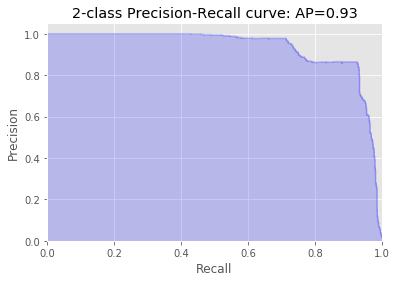

In [283]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score_model)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [279]:
p, r, thresholds = precision_recall_curve(y_test, y_score_model)

In [280]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

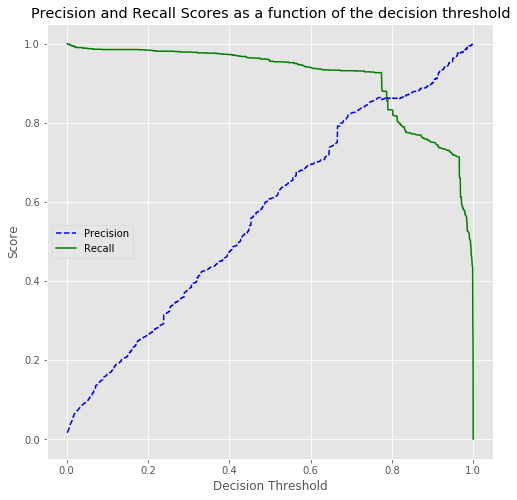

In [284]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [297]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_score_model, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_pos', 'pred_neg'], 
                       index=['pos', 'neg']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0, 1.01]);
    plt.xlim([0, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

     pred_pos  pred_neg
pos   3340300       225
neg       102      1318


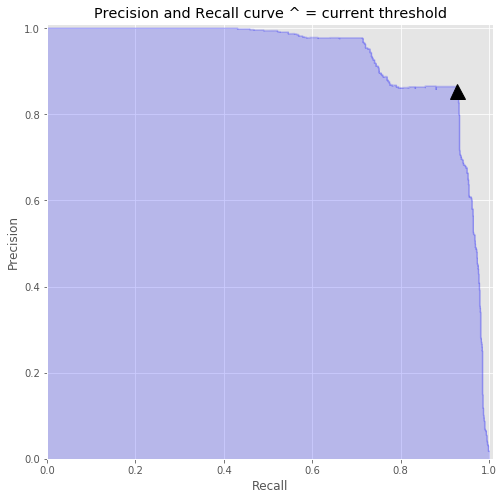

In [301]:
from sklearn.metrics import confusion_matrix
precision_recall_threshold(p, r, thresholds, .75)

     pred_pos  pred_neg
pos   3339648       877
neg        63      1357


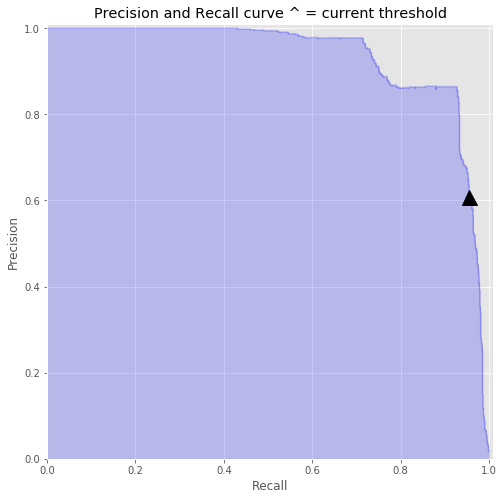

In [302]:
precision_recall_threshold(p, r, thresholds, .5)